<a href="https://colab.research.google.com/github/DerrickL25/snntorch/blob/master/examples/dataset_examples/SNN_Tutorial_Derrick_Lee.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/snntorch_alpha_w.png?raw=true' width="400">](https://github.com/jeshraghian/snntorch/)


# snnTorch - Training Spiking Neural Networks with snnTorch
### By Derrick Lee




The snnTorch tutorial series is based on the following paper. If you find these resources or code useful in your work, please consider citing the following source:

> <cite> [Jason K. Eshraghian, Max Ward, Emre Neftci, Xinxin Wang, Gregor Lenz, Girish Dwivedi, Mohammed Bennamoun, Doo Seok Jeong, and Wei D. Lu. "Training Spiking Neural Networks Using Lessons From Deep Learning". Proceedings of the IEEE, 111(9) September 2023.](https://ieeexplore.ieee.org/abstract/document/10242251) </cite>



## Introduction
In this tutorial you will learn how to:

* Train a spiking convolutional SNN
* Construct a dataloader using [Tonic](https://tonic.readthedocs.io/en/latest/#)
* To train a model on the [DVS Gesture Dataset](https://research.ibm.com/interactive/dvsgesture/)

If running in Google Colab:
* You may connect to GPU by checking `Runtime` > `Change runtime type` > `Hardware accelerator: GPU`
* Next, install the latest PyPi distribution of snnTorch by clicking into the following cell and pressing `Shift+Enter`.

In [ ]:
!pip install tonic --quiet
!pip install snntorch --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.7/109.7 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.7/112.7 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.0/109.0 kB 3.0 MB/s eta 0:00:00


In [ ]:
# imports
import tonic
import matplotlib.pyplot as plt
import tonic.transforms as transforms

import torch
import torchvision

import snntorch as snn
from snntorch import surrogate
from snntorch import functional as SF
from snntorch import utils
import torch.nn as nn

# 1. Dataset

The dataset used in this tutorial will be DVSGesture from IBM.
\
This dataset is comprised of 11 classes, where each corresponds to a hand gesture, like waving or clapping. All events were recorded on a DVS128 camera, which is a vision sensor that captures changes in the environment (events), represented by illuminated pixels, while static backdrops are ignored or produce little noise.


## 1.1 Loading the dataset with Tonic

In [ ]:
dataset = tonic.datasets.DVSGesture(save_to='./data', train=True)
events, label = dataset[0]

# Dataset size
print("Dataset contains ", len(dataset), " samples.")

# Number of events in the first sample
print("There are ", len(events), " events in the first sample.")

# (x-pos, y-pos, polarity, timestamp)
print("A single event: ", events[0])

  0%|          | 0/2443675558 [00:00<?, ?it/s]

Extracting ./data/DVSGesture/ibmGestureTrain.tar.gz to ./data/DVSGesture
Dataset contains  1077  samples.
There are  787770  events in the first sample.
A single event:  (119, 113, False, 6)


## 1.2 Visualizing the Data

(787, 2, 128, 128)


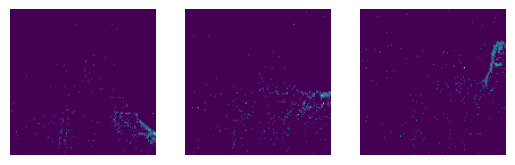

In [ ]:
# This is not necessary, but is cool to see
# Converting 1000 event blocks into frames with tonic.transforms.ToFrame
sensor_size = tonic.datasets.DVSGesture.sensor_size
frame_transform = tonic.transforms.ToFrame(sensor_size=sensor_size, event_count=1000)

# Applying the transform to the raw events array
frames = frame_transform(events)

# Shape of the frames object represents (num frames, polarity, width, height)
print(frames.shape)

# Plot some frames
fig, ax = plt.subplots(1, 3)
ax[0].axis('off')
ax[1].axis('off')
ax[2].axis('off')
ax[0].imshow(frames[0][0])
ax[1].imshow(frames[10][0])
ax[2].imshow(frames[20][0])

# 2. Transforming the Raw Data

## 2.1 Transforms
A neural network takes in a tensor as input, so the event array must be transformed into a suitable format.
\
The following code bins events into 1ms groups and denoises each group, or frame. These transforms are then applied to the train and test sets before being passed into dataloaders, which efficiently preprocess the data before passing it into the network.

Shape of frames object:  (25, 2, 128, 128)


  0%|          | 0/691455012 [00:00<?, ?it/s]

Extracting ./data/DVSGesture/ibmGestureTest.tar.gz to ./data/DVSGesture
1077
264


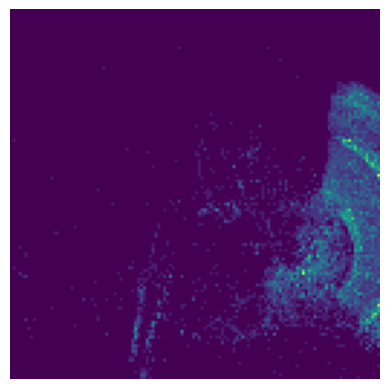

In [ ]:
size = tonic.datasets.DVSGesture.sensor_size

# Denoise transform removes outlier events with inactive surrounding pixels for 10ms
denoise_transform = transforms.Denoise(filter_time=10000)

# ToFrame transform bins events into 25 clusters of frames
frame_transform = transforms.ToFrame(sensor_size=size, n_time_bins=25)

# Chain the transforms
all_transform = transforms.Compose([denoise_transform, frame_transform])

# View the transformed data
tf_frames = all_transform(events)
print("Shape of frames object: ", tf_frames.shape)
plt.axis('off')
plt.imshow(tf_frames[0][0])

train_set = tonic.datasets.DVSGesture(save_to='./data', transform=all_transform, train=True)
test_set = tonic.datasets.DVSGesture(save_to='./data', transform=all_transform, train=False)
print(len(train_set))
print(len(test_set))

## 2.2 Caching and Dataloaders
- To optimize and expedite the training process, caching and dataloaders are helpful.
- A dataloader efficiently prepares data for iteration through shuffling, batch size processing, etc.
- Caching the dataset makes iterating through the dataloader much faster, as samples are read from the cache rather than from the disk.

In [ ]:
cached_trainset = tonic.DiskCachedDataset(train_set, cache_path='./cache/dvsgesture/train')
cached_testset = tonic.DiskCachedDataset(test_set, cache_path='./cache/dvsgesture/test')

# Create DataLoaders
train_loader = torch.utils.data.DataLoader(cached_trainset, batch_size=64, shuffle=True, drop_last=True, collate_fn=tonic.collation.PadTensors(batch_first=False))
test_loader = torch.utils.data.DataLoader(cached_testset, batch_size=32, shuffle=True, drop_last=True, collate_fn=tonic.collation.PadTensors(batch_first=False))

# Visualize shape of sample in dataloader (similar to frames object above, but 2nd element is batch size)
for sample in iter(train_loader):
  print("Shape of sample object: ", sample[0].shape)
  break

Shape of sample object:  torch.Size([25, 64, 2, 128, 128])


# 3. Building the Network

The network will be fairly simple; 2 convolution layers with 5 filters each, followed by a fully connected layer.

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [ ]:
# Network parameters
gradient = surrogate.fast_sigmoid(slope=25)
beta = 0.5

# Initializing the network
net = nn.Sequential(nn.Conv2d(2, 12, 5),
                    nn.MaxPool2d(2),
                    snn.Leaky(beta=beta, spike_grad=gradient, init_hidden=True),
                    nn.Conv2d(12, 32, 5),
                    nn.MaxPool2d(2),
                    snn.Leaky(beta=beta, spike_grad=gradient, init_hidden=True),
                    nn.Flatten(),
                    nn.Linear(800, 11),
                    snn.Leaky(beta=beta, spike_grad=gradient, init_hidden=True, output=True)
                    ).to(device)



## 3.1 Forward Propagation

Since the samples can be interpreted as a short video of 25 frames, a custom forward propagation function helps feed each frame, or cluster of events, into the network one at a time.

- In this case, data.size(0) == 25.

A single forward pass returns a tensor representing the spiking activity from one sample (or batch if batch size > 1).

This should be of size (frame count, batch size, num classes), or (25, 64, 11).

In [ ]:
# Defining a forward propagation function
def forward_pass(net, data):
  spk_rec = []
  snn.utils.reset(net)
  for step in range(data.size(0)):
      spk_out, mem_out = net(data[step])
      spk_rec.append(spk_out)
  return torch.stack(spk_rec)

In [ ]:
# some hyperparameters
optimizer = torch.optim.Adam(net.parameters(), lr=0.002, betas=(0.9, 0.999))
loss_fn = SF.mse_count_loss(correct_rate=0.8, incorrect_rate=0.2)

# 4. Training

Note: Dataloading will be slow for the first (num samples/batch size) training steps due to first time loading into the cache

In [ ]:
# 50 epochs; counter just used for test set validation
num_epochs = 50
counter = 0

loss_hist = []
acc_hist = []
test_acc_hist = []

# Training loop
for epoch in range(num_epochs):
    for i, (data, targets) in enumerate(iter(train_loader)):
        # Downsampling image from (128 x 128) to (32 x 32)
        data = nn.functional.interpolate(data, size=(2, 32, 32))
        data = data.to(device)
        targets = targets.to(device)

        net.train()
        # propagating one batch through the network and evaluating loss
        spk_rec = forward_pass(net, data)
        loss_val = loss_fn(spk_rec, targets)

        # Gradient calculation + weight update
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        # Store loss history for future plotting
        loss_hist.append(loss_val.item())

        acc = SF.accuracy_rate(spk_rec, targets)
        acc_hist.append(acc)

        # print metrics every so often
        if counter % 16 == 0:
          print(f"Epoch {epoch}, Iteration {i} \nTrain Loss: {loss_val.item():.2f}")
          print(f"Train Accuracy: {acc * 100:.2f}%\n")

          correct = 0
          total = 0

          for i, (data, targets) in enumerate(iter(test_loader)):
            data = nn.functional.interpolate(data, size=(2, 32, 32))
            data = data.to(device)
            targets = targets.to(device)
            spk_rec = forward_pass(net, data)
            correct += SF.accuracy_rate(spk_rec, targets) * spk_rec.size(1)
            total += spk_rec.size(1)

          test_acc = (correct/total) * 100
          test_acc_hist.append(test_acc)
          print(f"========== Test Set Accuracy: {test_acc:.2f}% ==========\n")

        counter += 1

Epoch 0, Iteration 0 
Train Loss: 2.36
Train Accuracy: 10.94%

========== Test Set Accuracy: 8.98% ==========

Epoch 1, Iteration 0 
Train Loss: 1.28
Train Accuracy: 29.69%

========== Test Set Accuracy: 35.16% ==========

Epoch 2, Iteration 0 
Train Loss: 0.93
Train Accuracy: 65.62%

========== Test Set Accuracy: 58.20% ==========

Epoch 3, Iteration 0 
Train Loss: 0.72
Train Accuracy: 50.00%

========== Test Set Accuracy: 60.16% ==========

Epoch 4, Iteration 0 
Train Loss: 0.62
Train Accuracy: 57.81%

========== Test Set Accuracy: 61.33% ==========

Epoch 5, Iteration 0 
Train Loss: 0.57
Train Accuracy: 70.31%

========== Test Set Accuracy: 65.23% ==========

Epoch 6, Iteration 0 
Train Loss: 0.45
Train Accuracy: 71.88%

========== Test Set Accuracy: 64.45% ==========

Epoch 7, Iteration 0 
Train Loss: 0.45
Train Accuracy: 71.88%

========== Test Set Accuracy: 64.84% ==========

Epoch 8, Iteration 0 
Train Loss: 0.38
Train Accuracy: 84.38%

========== Test Set Accuracy: 66.80% =====

# 5. Results

Plotting the accuracy on the training set, loss, and test set accuracy can help visualize how well the model is performing.
As we can see from the plots below, loss is converging and train/test accuracy is plateauing accordingly.

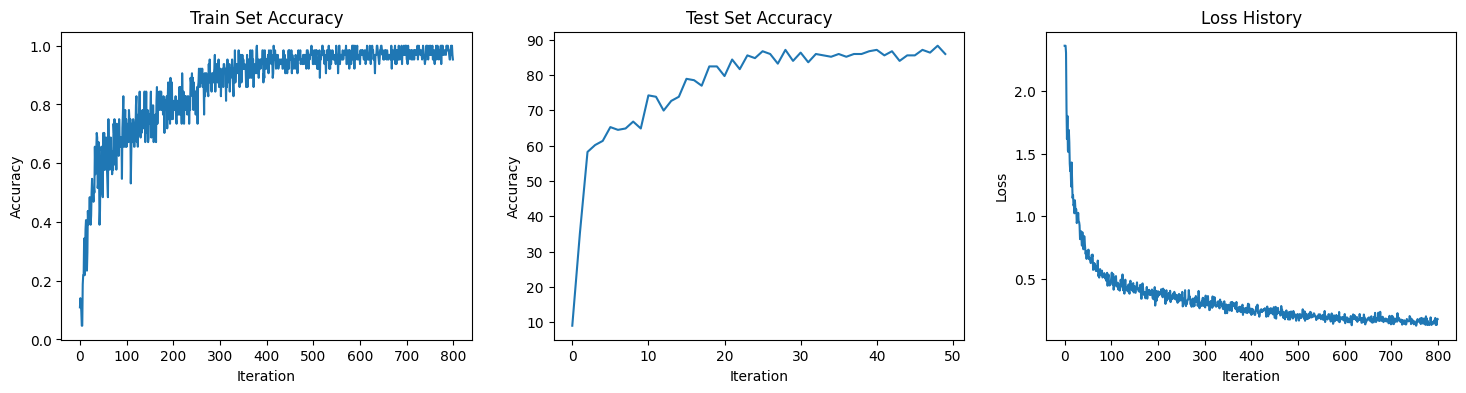

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18,4))

# Plot Train Accuracy
axes[0].plot(acc_hist)
axes[0].set_title("Train Set Accuracy")
axes[0].set_xlabel("Iteration")
axes[0].set_ylabel("Accuracy")

# Plot Test Accuracy
axes[1].plot(test_acc_hist)
axes[1].set_title("Test Set Accuracy")
axes[1].set_xlabel("Iteration")
axes[1].set_ylabel("Accuracy")

# Plot Training Loss
axes[2].plot(loss_hist)
axes[2].set_title("Loss History")
axes[2].set_xlabel("Iteration")
axes[2].set_ylabel("Loss")

plt.show()

In [ ]:
# Evaluate Test Set Accuracy
correct = 0
total = 0

for i, (data, targets) in enumerate(iter(test_loader)):
  data = nn.functional.interpolate(data, size=(2, 32, 32))
  data = data.to(device)
  targets = targets.to(device)
  spk_rec = forward_pass(net, data)
  correct += SF.accuracy_rate(spk_rec, targets) * spk_rec.size(1)
  total += spk_rec.size(1)

print("Test Set Accuracy: ", (correct/total) * 100, "%")

Test Set Accuracy:  85.546875 %
